In [1]:
import syft as sy

# Part 1: Join the Duet Server the Data Owner connected to

In [2]:
duet = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


### <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-light.png" alt="he-black-box" width="100"/> Checkpoint 0 : Now STOP and run the Data Owner notebook until Checkpoint 1.

# Part 2: Search for Available Data


In [3]:
# The data scientist can check the list of searchable data in Data Owner's duet store
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 316abc252b444dcda79505d17c77be45>,[Loan-data],This is a train dataset for Credit Default cla...,<class 'torch.Tensor'>
1,<UID: dbff274fcc8e41258f0a7587cfc4d517>,[Loan-target],"Labels for Defaulted: No, Yes",<class 'torch.Tensor'>


Data Scientist wants to use the iris dataset. (S)He needs a pointer to the data and
a pointer to the target for prediction.

In [4]:
data_ptr = duet.store[0]
target_ptr = duet.store[1]

`data_ptr` is a reference to the iris dataset remotely available on data owner's server.
`target_ptr` is a reference to the iris dataset LABELS remotely available on data owner's server

In [5]:
print(data_ptr)
print(target_ptr)

# Part 3: Perform Logistic Regression on Iris dataset
Now the data scientist can perform machine learning on the data that is in the Data Owner's duet server, without the owner having to share his/her data.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to be explicitly shared by the Data Owner. Let's try to find them in the data description.

In [6]:
print(duet.store.pandas["Description"][0])
print()
print(duet.store.pandas["Description"][1])

This is a train dataset for Credit Default classification.

Labels for Defaulted: No, Yes


### Train model

In [8]:
import pandas as pd
import numpy as np
import csv
from random import seed
from csv import reader 
import torch

In [9]:
in_dim = 71
out_dim = 2
n_samples = 8360

First, let's create our model for `Logistic Regression`. If you are already familiar with PyTorch, you will notice that the model is built almost the exact same way as you do in PyTorch. The main difference is that here we inherit from `sy.Module` instead of `nn.Module`. We also need to pass in a variable called `torch_ref` which we will use internally for any calls that you would normally make to torch.

In [27]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 100)
        self.layer2 = self.torch_ref.nn.Linear(100, 100)
        self.out = self.torch_ref.nn.Linear(100, out_dim)

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output


Now we can create a local model by passing our local copy of torch.

In [28]:
local_model = SyNet(torch)

Now we will send the local copy of the model to our partner's duet server.

In [29]:
remote_model = local_model.send(duet)

Let's create an alias for our partner’s torch called `remote_torch` so we can refer to the local torch as torch and any operation we want to do remotely as `remote_torch`. Remember, the return values from `remote_torch` are Pointers, not the real objects. They mostly act the same when using them with other Pointers but they cannot be mixed with local torch objects.

In [30]:
remote_torch = duet.torch

We will get a pointer to our remote model parameters. Then we will set our optimizer. Here, we will be using `Adam optimizer`. `params` is a pointer to the list of parameters. `optim` is a reference to the Adam optimizer which can be used to optimize the remote model.

In [31]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)
print("params:", params)
print("optim:", optim)

params: <syft.proxy.syft.lib.python.ListPointer object at 0x000001D622FDEEE0>
optim: <syft.proxy.torch.optim.AdamPointer object at 0x000001D6260A5E80>


Now we will create our `train` function. It will take few parameters, like the `remote_model`, `torch_ref`, `optim` and `data_ptr` and `target_ptr`.

In [32]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        # nll_loss = negative log-liklihood loss
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress", request_block=True, timeout_secs=5
        )

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

In [33]:
iteration = 300
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 0.7584929466247559
Epoch 10 loss 6.957126140594482
Epoch 20 loss 1.453076958656311
Epoch 30 loss 0.594415009021759
Epoch 40 loss 0.6550595164299011
Epoch 50 loss 0.5957709550857544
Epoch 60 loss 0.6107428073883057
Epoch 70 loss 0.5722336769104004
Epoch 80 loss 0.5943287014961243
Epoch 90 loss 0.5581899881362915
Epoch 100 loss 0.5390004515647888
Epoch 110 loss 0.5018261671066284
Epoch 120 loss 0.48123154044151306
Epoch 130 loss 0.4837459921836853
Epoch 140 loss 0.46877890825271606
Epoch 150 loss 0.4232300817966461
Epoch 160 loss 0.3804877698421478
Epoch 170 loss 0.4148845076560974
Epoch 180 loss 0.40979593992233276
Epoch 190 loss 0.32867974042892456
Epoch 200 loss 0.3198102116584778
Epoch 210 loss 0.36694151163101196
Epoch 220 loss 0.34351256489753723
Epoch 230 loss 0.36960098147392273
Epoch 240 loss 0.28568440675735474
Epoch 250 loss 0.27268755435943604
Epoch 260 loss 0.7776882648468018
Epoch 270 loss 0.33610501885414124
Epoch 280 loss 0.26562759280204773
Epoch 290 loss 0.

In [34]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

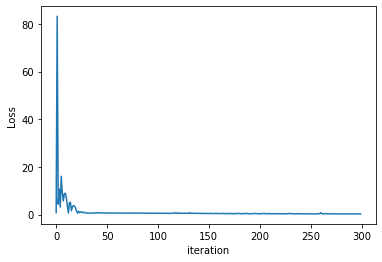

In [35]:
plt.plot(range(iteration), losses)
plt.ylabel("Loss")
plt.xlabel("iteration")

### Download model

In [36]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else:
        local_model = model

    return local_model


local_model = get_local_model(remote_model)

### Test on local data

In [37]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [38]:
project_test = pd.read_csv("C:/Data Science and Analytics/DSA 5900/Final Deliverable/Test.csv")
project_test.drop(['Unnamed: 0'] , axis = 1, inplace =True)

project_test = project_test.dropna()
project_test.head()

,VerificationType,LanguageCode,Age,Gender,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,UseOfLoan,...,Rating_F,Rating_HR,Rating_nan,Status_Late,Status_Repaid,Status_nan,Restructured_True,Restructured_nan,diff_days,Defaulted
0,4.0,1,0.442308,1.0,0.292715,0.292715,0.061933,0.282051,0.056659,2,...,0,0,0,0,1,0,0,0,1125.0,1
1,4.0,1,0.576923,1.0,0.414284,0.414284,0.140012,1.000000,0.065239,9,...,0,0,0,1,0,0,0,0,3639.0,1
2,4.0,3,0.442308,1.0,0.192136,0.192136,0.076600,0.487179,0.028883,9,...,0,0,0,0,1,0,0,0,1820.0,1
3,4.0,6,0.519231,2.0,0.141229,0.141229,0.197744,0.487179,0.036761,9,...,1,0,0,0,1,0,0,0,125.0,0
4,4.0,4,0.346154,0.0,0.039415,0.039415,0.053530,0.487179,0.005704,9,...,0,0,0,0,0,0,0,0,1819.0,0


In [39]:
X_test = project_test.loc[:, project_test.columns != "Defaulted"]
y_test = project_test["Defaulted"]



In [40]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [41]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 1
Prediction

In [42]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 87.6555023923445
